## Business Problem: 
The topic studied is healthcare frauds. It is one of the biggest problems, influencing both individuals and businesses. Healthcare fraud involve providers, physicians, beneficiaries acting together to make fraud claims.  
Some of the most common types of frauds by providers are billing for services that were not provided, duplicate submission of a claim for the same service, misrepresenting the service provided and charging for a more complex or expensive service than was actually provided. 
The Insurance companies are the most vulnerable institutions impacted, which can lead to a raise in their insurance premiums and as result healthcare is becoming costly matter day by day. 
In this project, I want to detect Medicare fraudulent claims based on basically the number of claims filled and services provided, find the important features helpful in detecting this behavior and describe the patterns in providers or prescribers’ claims to understand their future behavior. 

## Dataset: 
The data used was sourced from the centers for Medicare and Medicaid Services (CMS) website. I selected two datasets: 
- The Medicare Physician & Other Practitioners by Provider and Service dataset 
- Medicare Part D Prescribers - by Provider and Drug dataset
Based on the goal of my project, I kept just few features from the two datasets. So, I merged the two 
datasets, using the common column provider or prescriber NPI, to get data that satisfies our needs. I utilized MySQL to load and merge two datasets.

## Methods:
To detect frauds from non-frauds, I assumed that fraud correlates with high costs or excessive number of claims. Then, I fixed  tresholds for acceptable normal costs and claims counts. If these tresholds were exceeded, I consider it a fraud, otherwise, it is normal (no fraud detected).
The model used is the logistic regression, simple and interpretable model. 

## Importing libraries:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

## Data Loading & Understanding:

In [3]:
#load data
# Ensure all columns are displayed
pd.set_option('display.max_columns', None)
data= pd.read_csv(r"C:\Users\sanas\OneDrive\Desktop\Data for 680 project1\new_data.csv")

In [6]:
# view few rows
data.head()

Prscrbr_NPI Prscrbr_Last_Org_Name Prscrbr_First_Name       Prscrbr_Type  \
0   1003000126             Enkeshafi            Ardalan  Internal Medicine   
1   1003000126             Enkeshafi            Ardalan  Internal Medicine   
2   1003000126             Enkeshafi            Ardalan  Internal Medicine   
3   1003000126             Enkeshafi            Ardalan  Internal Medicine   
4   1003000126             Enkeshafi            Ardalan  Internal Medicine   

              Brnd_Name  Tot_Clms  Tot_30day_Fills  Tot_Day_Suply  \
0            Prednisone        11             11.2             88   
1    Pravastatin Sodium        14             22.2            663   
2   Pantoprazole Sodium        24             35.1           1052   
3  Metoprolol Succinate        12             24.0            720   
4    Losartan Potassium        13             33.0            990   

   Tot_Drug_Cst  Rndrng_Prvdr_Type  HCPCS_Cd  Tot_Srvcs  
0         59.42  Internal Medicine     99217         44  
1        300.52  Internal Medicine     99217         44  
2        429.87  Internal Medicine     99217         44  
3        141.86  Internal Medicine     99217         44  
4        189.60  Internal Medicine     99217         44

In [5]:
data.shape

(39563, 12)

In [17]:
data.columns

Index(['Prscrbr_NPI', 'Prscrbr_Last_Org_Name', 'Prscrbr_First_Name',
       'Prscrbr_Type', 'Brnd_Name', 'Tot_Clms', 'Tot_30day_Fills',
       'Tot_Day_Suply', 'Tot_Drug_Cst', 'Rndrng_Prvdr_Type', 'HCPCS_Cd',
       'Tot_Srvcs'],
      dtype='object')

In [18]:
# data overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39563 entries, 0 to 39562
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Prscrbr_NPI            39563 non-null  int64  
 1   Prscrbr_Last_Org_Name  39563 non-null  object 
 2   Prscrbr_First_Name     39563 non-null  object 
 3   Prscrbr_Type           39563 non-null  object 
 4   Brnd_Name              39563 non-null  object 
 5   Tot_Clms               39563 non-null  int64  
 6   Tot_30day_Fills        39563 non-null  float64
 7   Tot_Day_Suply          39563 non-null  int64  
 8   Tot_Drug_Cst           39563 non-null  float64
 9   Rndrng_Prvdr_Type      39563 non-null  object 
 10  HCPCS_Cd               39563 non-null  int64  
 11  Tot_Srvcs              39563 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 3.6+ MB


## Data Cleaning:

In [19]:
# check for missing data
data.isnull().sum()

Prscrbr_NPI              0
Prscrbr_Last_Org_Name    0
Prscrbr_First_Name       0
Prscrbr_Type             0
Brnd_Name                0
Tot_Clms                 0
Tot_30day_Fills          0
Tot_Day_Suply            0
Tot_Drug_Cst             0
Rndrng_Prvdr_Type        0
HCPCS_Cd                 0
Tot_Srvcs                0
dtype: int64

In [20]:
# check for duplicates
data.duplicated().sum()

0

In [21]:
#Renaming columns
data = data.rename(columns={'Prscrbr_NPI':'Prescriber_NPI', 'Prscrbr_Last_Org_Name': 'Prescriber_LN', 'Prscrbr_First_Name':'Prescriber_FN',
       'Prscrbr_Type':'Prescriber_Type', 'Brnd_Name':'Brand_Name', 'Tot_Clms':'Total_Claims', 'Rndrng_Prvdr_Type':'Provider_Type',
       'HCPCS_Cd':'HCPCS_Code', 'Tot_Srvcs':'Total_Services'})


In [22]:
# concatenate the columns 'Prescriber/Provider_LN' and 'Prescriber/Provider_FN' to get one column ''Prescriber/Provider_FN'
data['Prescriber_FullName'] = data['Prescriber_FN'] + " " + data['Prescriber_LN']


In [23]:
#drop the columns 'Prescriber/Provider_LN' and 'Prescriber/Provider_FN'
data.drop(columns=['Prescriber_LN','Prescriber_FN'], axis=1,  inplace=True)

In [37]:
# create new columns
data['Avg_Cost_per_Claim'] = data['Tot_Drug_Cst'] / data['Total_Claims']
data['Claims_per_Service'] = data['Total_Claims'] / data['Total_Services']

In [38]:
# check the updates
data.head()

Prescriber_NPI    Prescriber_Type            Brand_Name  Total_Claims  \
0      1003000126  Internal Medicine            Prednisone            11   
1      1003000126  Internal Medicine    Pravastatin Sodium            14   
2      1003000126  Internal Medicine   Pantoprazole Sodium            24   
3      1003000126  Internal Medicine  Metoprolol Succinate            12   
4      1003000126  Internal Medicine    Losartan Potassium            13   

   Tot_30day_Fills  Tot_Day_Suply  Tot_Drug_Cst      Provider_Type  \
0             11.2             88         59.42  Internal Medicine   
1             22.2            663        300.52  Internal Medicine   
2             35.1           1052        429.87  Internal Medicine   
3             24.0            720        141.86  Internal Medicine   
4             33.0            990        189.60  Internal Medicine   

   HCPCS_Code  Total_Services Prescriber_FullName  Avg_Cost_per_Claim  \
0       99217              44   Ardalan Enkeshafi            5.401818   
1       99217              44   Ardalan Enkeshafi           21.465714   
2       99217              44   Ardalan Enkeshafi           17.911250   
3       99217              44   Ardalan Enkeshafi           11.821667   
4       99217              44   Ardalan Enkeshafi           14.584615   

   Claims_per_Service  
0            0.250000  
1            0.318182  
2            0.545455  
3            0.272727  
4            0.295455

## Data Exploration:

In [25]:
# statistic overview

In [26]:
data.describe(include='number')

Prescriber_NPI  Total_Claims  Tot_30day_Fills  Tot_Day_Suply  \
count    3.956300e+04  39563.000000     39563.000000   39563.000000   
mean     1.003008e+09     60.509618       117.943156    3397.406870   
std      3.601511e+03     92.903360       185.482094    5497.440276   
min      1.003000e+09     11.000000        11.000000      13.000000   
25%      1.003006e+09     16.000000        27.000000     660.000000   
50%      1.003008e+09     28.000000        50.400000    1414.000000   
75%      1.003010e+09     66.000000       120.000000    3422.000000   
max      1.003012e+09   2662.000000      3830.600000  105314.000000   

       Tot_Drug_Cst    HCPCS_Code  Total_Services  
count  3.956300e+04  39563.000000    39563.000000  
mean   9.476597e+03  88587.793646      107.703283  
std    4.429032e+04  18086.722512      274.582436  
min    9.330000e+00   1938.000000       11.000000  
25%    3.335100e+02  87428.000000       20.000000  
50%    9.093000e+02  93978.000000       36.000000  
75%    3.181000e+03  99214.000000       96.000000  
max    1.166852e+06  99497.000000     6889.000000

- 75% of total services are equal or less the 96 while there is a maximum of 6889.
- 75% of total claims are equal or less the 66 while there is a maximum of 2662.

This suggests the availability of certain extreme numbers of claims and services that can correspond to frauds.


In [27]:
data.describe(include='object')

Prescriber_Type  Brand_Name    Provider_Type Prescriber_FullName
count             39563       39563            39563               39563
unique               32         585               32                 113
top     Family Practice  Gabapentin  Family Practice      Sam Fereidouni
freq              13161         508            13161                3225

The data includes 113 unique, different providers and prescribers, 32 unique service provider and 585 unique drug types.
The mostly frequent service provider type is Family Practice. 

## Data Visualization

In [28]:
data.head()

Prescriber_NPI    Prescriber_Type            Brand_Name  Total_Claims  \
0      1003000126  Internal Medicine            Prednisone            11   
1      1003000126  Internal Medicine    Pravastatin Sodium            14   
2      1003000126  Internal Medicine   Pantoprazole Sodium            24   
3      1003000126  Internal Medicine  Metoprolol Succinate            12   
4      1003000126  Internal Medicine    Losartan Potassium            13   

   Tot_30day_Fills  Tot_Day_Suply  Tot_Drug_Cst      Provider_Type  \
0             11.2             88         59.42  Internal Medicine   
1             22.2            663        300.52  Internal Medicine   
2             35.1           1052        429.87  Internal Medicine   
3             24.0            720        141.86  Internal Medicine   
4             33.0            990        189.60  Internal Medicine   

   HCPCS_Code  Total_Services Prescriber_FullName  
0       99217              44   Ardalan Enkeshafi  
1       99217              44   Ardalan Enkeshafi  
2       99217              44   Ardalan Enkeshafi  
3       99217              44   Ardalan Enkeshafi  
4       99217              44   Ardalan Enkeshafi

In [29]:
# distributions of total claims and total services

In [30]:

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for Total Claims
sns.histplot(data['Total_Claims'], bins=10, kde=True, ax=axes[0], color='blue')
axes[0].set_title("Distribution of Total Claims")
axes[0].set_xlabel("Total Claims")
axes[0].set_ylabel("Frequency")

# Histogram for Total Services
sns.histplot(data['Total_Services'], bins=10, kde=True, ax=axes[1], color='green')
axes[1].set_title("Distribution of Total Services")
axes[1].set_xlabel("Total Services")
axes[1].set_ylabel("Frequency")

# Show the plots
plt.tight_layout()
plt.show()


The frequency is extremly high with low number of total claims and total services not exceeding 100. 
Total services and total claims have right-skewed distributions, suggesting that some prescribers have high claim counts, and some providers declarent they made extremely high number of services.

In [31]:
# Total claims by prescriber NPI

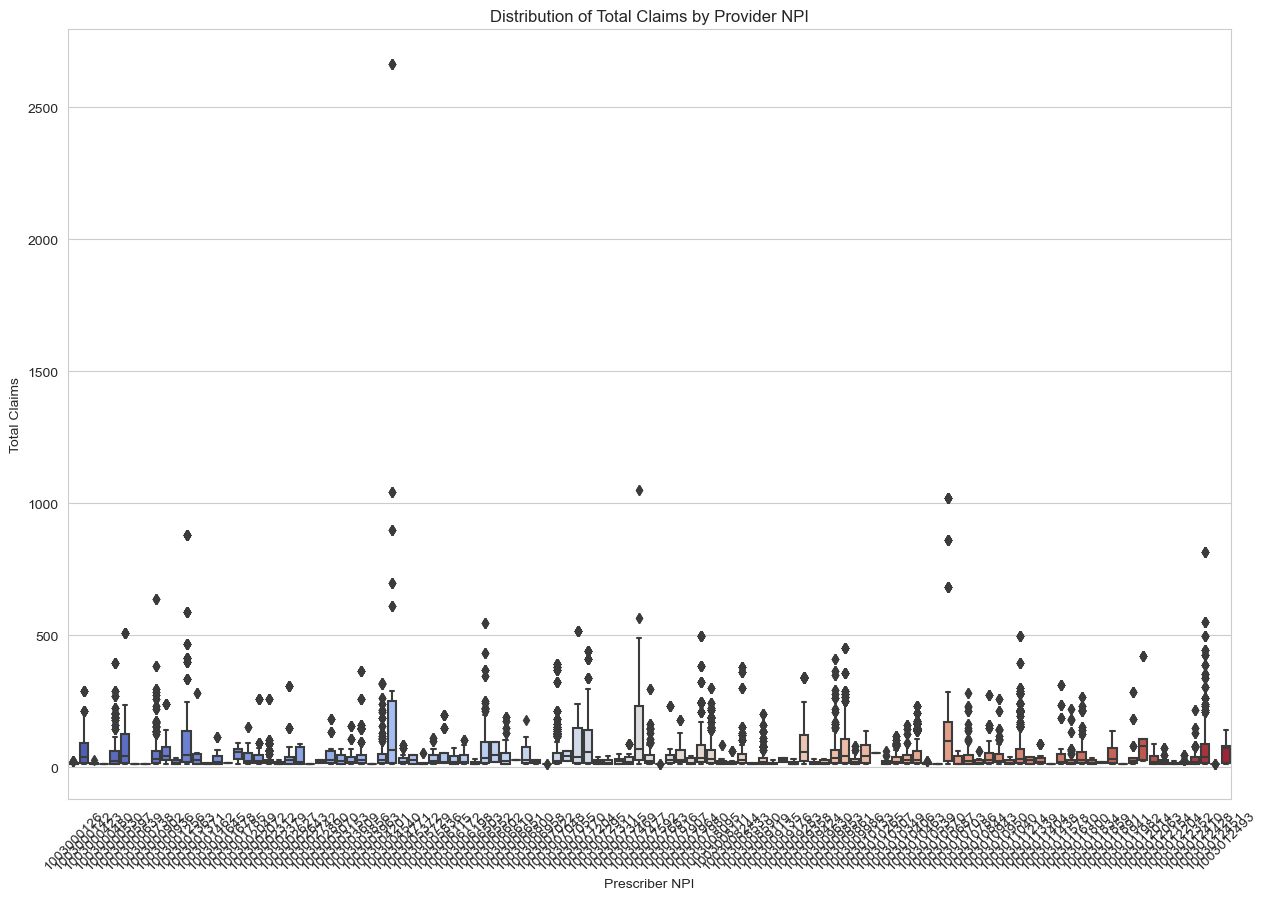

In [32]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='Prescriber_NPI', y='Total_Claims', data=data, palette='coolwarm')
plt.xlabel("Prescriber NPI")
plt.ylabel("Total Claims")
plt.title("Distribution of Total Claims by Provider NPI")
plt.xticks(rotation=45)
plt.show()

The box plots highlight the extreme values in the total number of claims. High number of claims may correspond to suspicious providers.

In [350]:
# Claims vs. Drug Cost Scatter Plot

In [351]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x='Total_Claims', y='Tot_Drug_Cst', hue='Prescriber_Type', alpha=0.7)
plt.xlabel('Total Claims')
plt.ylabel('Total Drug Cost')
plt.title('Total Claims vs. Total Drug Cost')
plt.show()


Some specialities such as ophthalmology and cardiology are associated with high claims and high costs, that could indicate overprescribing expensive medications.

In [352]:
# Boxplot of Average Drug Cost Per Claim Per Prescriber

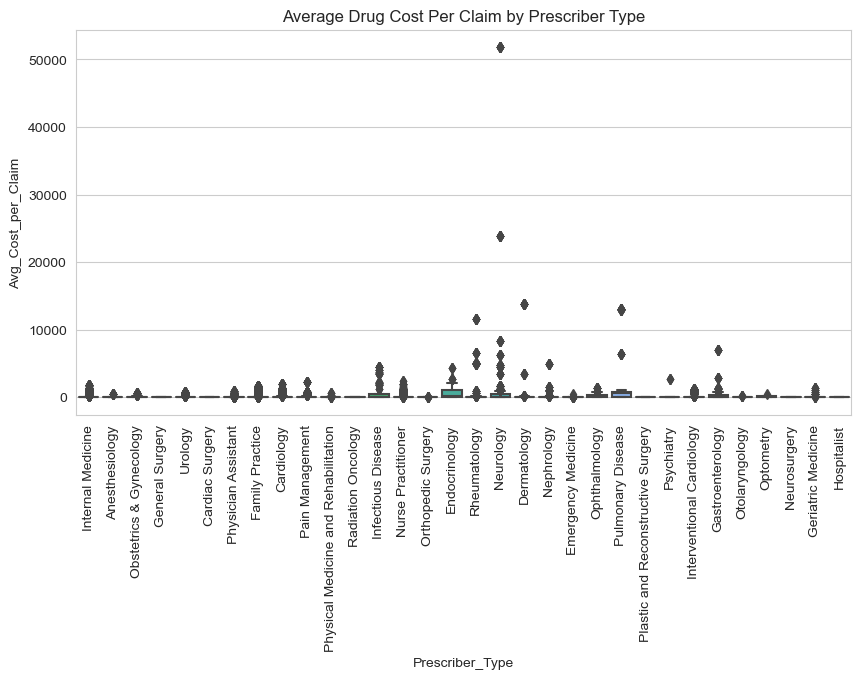

In [353]:

plt.figure(figsize=(10,5))
sns.boxplot(data=data, x='Prescriber_Type', y='Avg_Cost_per_Claim')
plt.xticks(rotation=90)
plt.title('Average Drug Cost Per Claim by Prescriber Type')
plt.show()


The average drug cost in all specialities is less than 10000, except the rheumatology, neurology, dermatology and pulmonary disease specialities. These could correspond to fraud actions in these specialities.

In [354]:
# Scatter plot: Services vs. Claims Ratio

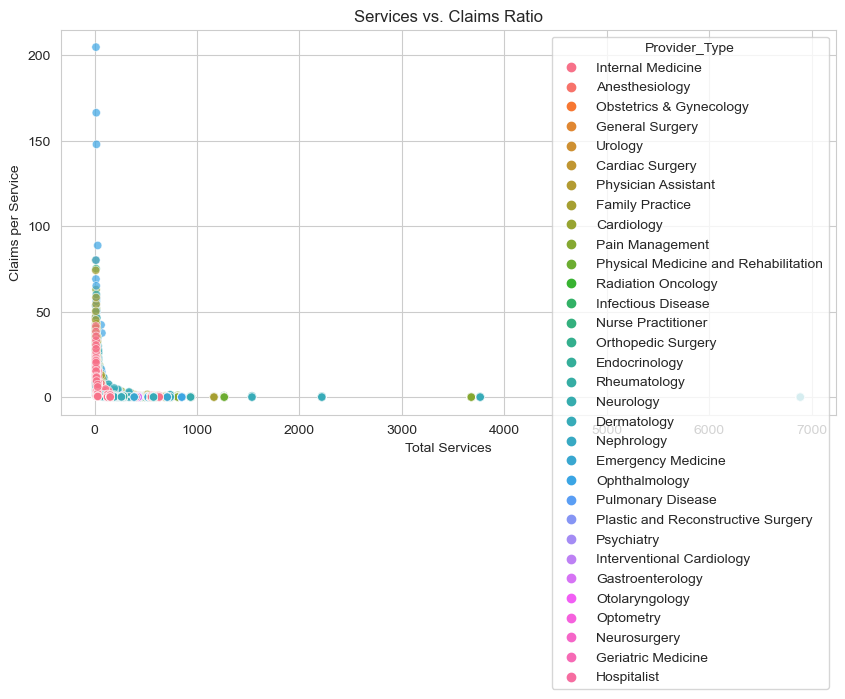

In [355]:

plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x='Total_Services', y='Claims_per_Service', hue='Provider_Type', alpha=0.7)
plt.xlabel('Total Services')
plt.ylabel('Claims per Service')
plt.title('Services vs. Claims Ratio')
plt.show()


- Most points in the plot are concentrated on the left site with low number of claims. A number of claims per service exceeding 50 could be suspicious, suggesting that providers are billing an unusually high number of claims for very few services, which could indicate fraudulent billing practices.

- Some providers on the right-hand side (high total services) have a claims-per-service ratio close to 0. This could indicate normal, high-volume providers.

In [356]:
# Heatmap of High-Prescribing Specialties

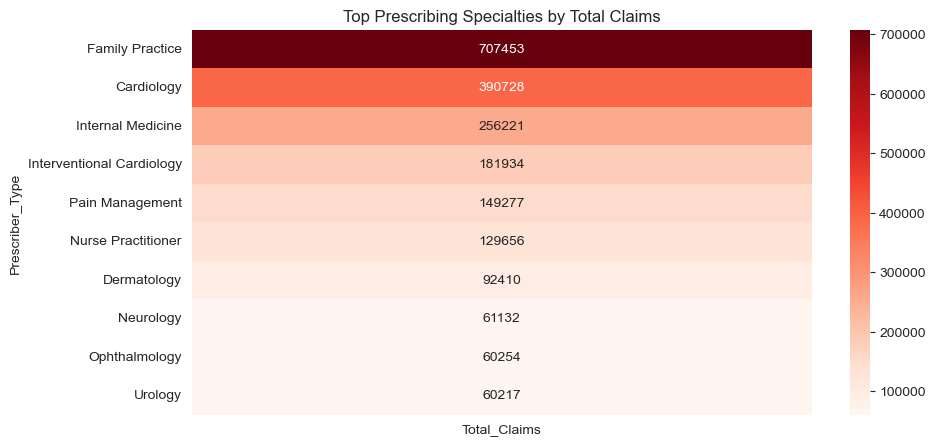

In [357]:
plt.figure(figsize=(10,5))
top_prescribers = data.groupby('Prescriber_Type')['Total_Claims'].sum().sort_values(ascending=False).head(10)
sns.heatmap(top_prescribers.to_frame(), cmap='Reds', annot=True, fmt='.0f')
plt.title('Top Prescribing Specialties by Total Claims')
plt.show()


The family practice, cardiology and internal medicine are the mostly prescribing specialities.

In [358]:
# Bar Chart of Most Prescribed Drugs by Suspicious Providers

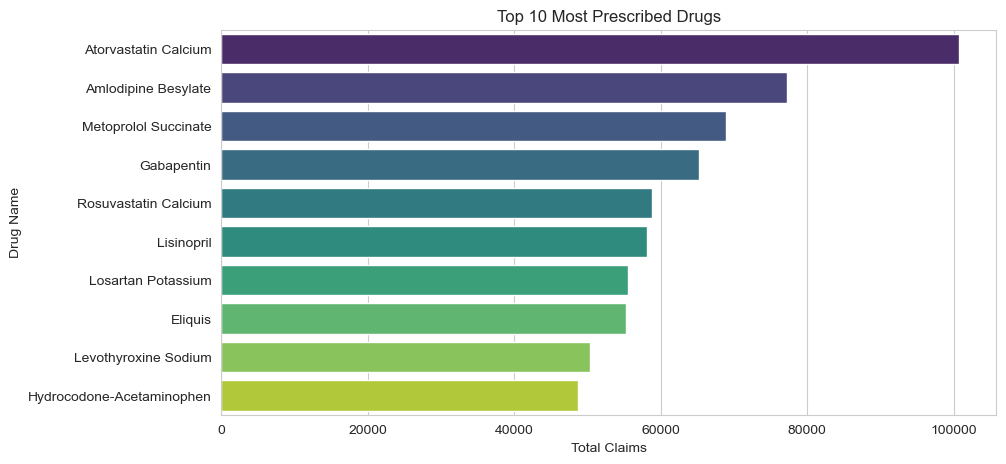

In [359]:
top_drugs = data.groupby('Brand_Name')['Total_Claims'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_drugs.values, y=top_drugs.index, palette='viridis')
plt.xlabel('Total Claims')
plt.ylabel('Drug Name')
plt.title('Top 10 Most Prescribed Drugs')
plt.show()


## Data Preprocessing

In [36]:
data.head()

Prescriber_NPI    Prescriber_Type            Brand_Name  Total_Claims  \
0      1003000126  Internal Medicine            Prednisone            11   
1      1003000126  Internal Medicine    Pravastatin Sodium            14   
2      1003000126  Internal Medicine   Pantoprazole Sodium            24   
3      1003000126  Internal Medicine  Metoprolol Succinate            12   
4      1003000126  Internal Medicine    Losartan Potassium            13   

   Tot_30day_Fills  Tot_Day_Suply  Tot_Drug_Cst      Provider_Type  \
0             11.2             88         59.42  Internal Medicine   
1             22.2            663        300.52  Internal Medicine   
2             35.1           1052        429.87  Internal Medicine   
3             24.0            720        141.86  Internal Medicine   
4             33.0            990        189.60  Internal Medicine   

   HCPCS_Code  Total_Services Prescriber_FullName  
0       99217              44   Ardalan Enkeshafi  
1       99217              44   Ardalan Enkeshafi  
2       99217              44   Ardalan Enkeshafi  
3       99217              44   Ardalan Enkeshafi  
4       99217              44   Ardalan Enkeshafi

In [364]:
# drop unuseful features for modeling

In [365]:
data.corr()

C:\Users\sanas\AppData\Local\Temp\ipykernel_82140\2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


Prescriber_NPI  Total_Claims  Tot_30day_Fills  \
Prescriber_NPI            1.000000     -0.018650         0.022548   
Total_Claims             -0.018650      1.000000         0.915572   
Tot_30day_Fills           0.022548      0.915572         1.000000   
Tot_Day_Suply             0.022195      0.890133         0.995494   
Tot_Drug_Cst             -0.005803      0.166054         0.117456   
HCPCS_Code                0.082838     -0.055268         0.016463   
Total_Services           -0.013139      0.055442         0.014234   
Avg_Cost_per_Claim       -0.000862     -0.039805        -0.051687   
Claims_per_Service       -0.009725      0.732359         0.695780   
Outlier_Flag             -0.011730      0.749621         0.778007   

                    Tot_Day_Suply  Tot_Drug_Cst  HCPCS_Code  Total_Services  \
Prescriber_NPI           0.022195     -0.005803    0.082838       -0.013139   
Total_Claims             0.890133      0.166054   -0.055268        0.055442   
Tot_30day_Fills          0.995494      0.117456    0.016463        0.014234   
Tot_Day_Suply            1.000000      0.117852    0.028368        0.008817   
Tot_Drug_Cst             0.117852      1.000000    0.007943        0.002868   
HCPCS_Code               0.028368      0.007943    1.000000       -0.014946   
Total_Services           0.008817      0.002868   -0.014946        1.000000   
Avg_Cost_per_Claim      -0.049251      0.705404   -0.005495        0.001105   
Claims_per_Service       0.681412      0.127045   -0.021970       -0.134420   
Outlier_Flag             0.769084      0.113688   -0.021754        0.025498   

                    Avg_Cost_per_Claim  Claims_per_Service  Outlier_Flag  
Prescriber_NPI               -0.000862           -0.009725     -0.011730  
Total_Claims                 -0.039805            0.732359      0.749621  
Tot_30day_Fills              -0.051687            0.695780      0.778007  
Tot_Day_Suply                -0.049251            0.681412      0.769084  
Tot_Drug_Cst                  0.705404            0.127045      0.113688  
HCPCS_Code                   -0.005495           -0.021970     -0.021754  
Total_Services                0.001105           -0.134420      0.025498  
Avg_Cost_per_Claim            1.000000           -0.031589     -0.038657  
Claims_per_Service           -0.031589            1.000000      0.548292  
Outlier_Flag                 -0.038657            0.548292      1.000000

-High correlation exist between:
    - Tot_30day_Fills and Total_Claims
    - Tot_Day_Suply and Tot_30day_Fills
    
So, I am going to drop the features Tot_Day_Suply and Tot_30day_Fills . 

In [46]:
# drop unnecessary features for model
data.drop(columns=['Prescriber_NPI', 'Prescriber_Type', 'Brand_Name', 'HCPCS_Code', 'Prescriber_FullName', 'Provider_Type', 'Tot_Day_Suply', 'Tot_30day_Fills'], inplace=True)


## Data Modeling:

In [54]:
# identify tresholds
threshold_cost = data['Avg_Cost_per_Claim'].quantile(0.90)
threshold_claims = data['Claims_per_Service'].quantile(0.90)

# create the feature fraud_label and convert it to integer, so, we can get 0 for non fraud and 1 for fraud.
data['Fraud_Label'] = ((data['Avg_Cost_per_Claim'] > threshold_cost) | 
                        (data['Claims_per_Service'] > threshold_claims)).astype(int)

print(data['Fraud_Label'])

0        0
1        0
2        0
3        0
4        0
        ..
39558    0
39559    1
39560    0
39561    0
39562    1
Name: Fraud_Label, Length: 39563, dtype: int32


In [55]:
# view data
data.head()

Total_Claims  Tot_Drug_Cst  Total_Services  Avg_Cost_per_Claim  \
0            11         59.42              44            5.401818   
1            14        300.52              44           21.465714   
2            24        429.87              44           17.911250   
3            12        141.86              44           11.821667   
4            13        189.60              44           14.584615   

   Claims_per_Service  Fraud_Label  
0            0.250000            0  
1            0.318182            0  
2            0.545455            0  
3            0.272727            0  
4            0.295455            0

In [56]:
# split the data 

# Define features and target variable
X = data.drop(columns=['Fraud_Label'])  
y = data['Fraud_Label']  

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shape of the new datasets
print(X_train.shape, X_test.shape)

(31650, 5) (7913, 5)


In [57]:
# check class distribution
print(data['Fraud_Label'].value_counts(normalize=True)) 

0    0.807371
1    0.192629
Name: Fraud_Label, dtype: float64


- The fraud cases in the dataset are much fewer than non-fraud cases. This imbalance in the dataset can affect model training. The, I consider oversampling the dataset with SMOTE.
- The regression model performs better with scaled data, then I consider scaling the different features with StandardScaler().

In [58]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [59]:
# Train Logistic Regression with class weight balancing
logreg = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
logreg.fit(X_train_scaled, y_train_resampled)

# Predictions
y_pred = logreg.predict(X_test_scaled)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[6252  137]
 [   4 1520]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      6389
           1       0.92      1.00      0.96      1524

    accuracy                           0.98      7913
   macro avg       0.96      0.99      0.97      7913
weighted avg       0.98      0.98      0.98      7913



## Interpretation:

The logistic regression model performed very well in detecting fraudulent claims. The overall accuracy is 98%, meaning the model correctly classified the majority of cases.

Non-Fraudulent Cases (0s): The model had 100% precision and 98% recall, meaning almost all non-fraudulent claims were correctly classified, with only 137 false positives (legitimate claims misclassified as fraud).

Fraudulent Cases (1s): The model had 92% precision (meaning 8% of flagged fraud cases were actually legitimate) and 100% recall, meaning it successfully identified all fraudulent claims with only 4 false negatives (actual fraud cases misclassified as legitimate).

F1-score (balance between precision & recall): 0.96 for fraudulent claims, showing strong overall detection performance.


The model is highly accurate and excellent at detecting fraud, with a very low false negative rate, ensuring minimal missed fraud cases. However, the false positive rate (137 cases) suggests that some legitimate claims might be flagged incorrectly, which could lead to some unnecessary investigations. However, overall this model is performing very well. 

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))